In [49]:
import os, importlib, sys, time

In [50]:
import numpy as np
import scipy.sparse as sparse
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import pyarrow
from tqdm import tqdm

In [51]:
import KECENI

# load data

In [52]:
data_dir = 'data'
save_dir = 'result_true'

In [53]:
data_network = pd.read_feather('%s/network.feather'%(data_dir))
data_latent = pd.read_feather('%s/latent.feather'%data_dir)

In [54]:
data_network

,row,col
0,1,244
1,2,416
2,2,536
3,2,540
4,2,726
...,...,...
3391,999,880
3392,1000,352
3393,1000,357
3394,1000,807


In [55]:
n_node = len(data_latent); n_node

1000

In [56]:
Adj = sparse.csr_matrix((
    np.full(len(data_network), True), 
    (np.array(data_network.row)-1, np.array(data_network.col)-1)
)).toarray()

In [57]:
G = KECENI.Graph(Adj)

# hyperparameters

In [58]:
from hyperparams import delta, HyperAlpha

# counterfactual of interest

In [59]:
i0 = 17

In [60]:
T1s = np.zeros(n_node); T1s[G.N1(i0)[::2]] = 1
T2s = T1s.copy(); T2s[i0] = 0

In [61]:
T1s[G.N1(i0)], T2s[G.N1(i0)]

(array([1., 0., 1., 0., 1.]), array([0., 0., 1., 0., 1.]))

# groundtruth

In [62]:
YTR_1, YTR_0 = (1, -1)
YTR_d = YTR_1 - YTR_0

In [63]:
YTR_0, YTR_1, YTR_d

(-1, 1, 2)

# estimation

In [64]:
n_sim = 80

## - load simulation

In [65]:
lamdas = np.linspace(0, 20, 21)[1:]
hops = np.array([5,6,7,8])

In [66]:
ids_cv = np.zeros(n_sim, dtype=int)

In [67]:
YGs_0 = np.zeros(n_sim); YGs_1 = np.zeros(n_sim); YGs_d = np.zeros(n_sim)
YDRs_0 = np.zeros(n_sim); YDRs_1 = np.zeros(n_sim); YDRs_d = np.zeros(n_sim)

In [68]:
sd0s_bbb_dr = np.zeros((n_sim,)+hops.shape); sd0s_hac_dr = np.zeros((n_sim,)+hops.shape)
sd1s_bbb_dr = np.zeros((n_sim,)+hops.shape); sd1s_hac_dr = np.zeros((n_sim,)+hops.shape)
sdds_bbb_dr = np.zeros((n_sim,)+hops.shape); sdds_hac_dr = np.zeros((n_sim,)+hops.shape)

In [69]:
for i_sim in np.arange(n_sim):
    locals().update(np.load('%s/result_%.3d.npz'%(save_dir,i_sim)))
    YGs_0[i_sim] = YG_0; YGs_1[i_sim] = YG_1; YGs_d[i_sim] = YG_d
    YDRs_0[i_sim] = YDR_0[id_cv]; YDRs_1[i_sim] = YDR_1[id_cv]; YDRs_d[i_sim] = YDR_d[id_cv]
    sd0s_bbb_dr[i_sim] = sd0_bbb_dr[:,id_cv]; sd0s_hac_dr[i_sim] = sd0_hac_dr[:,id_cv]
    sd1s_bbb_dr[i_sim] = sd1_bbb_dr[:,id_cv]; sd1s_hac_dr[i_sim] = sd1_hac_dr[:,id_cv]
    sdds_bbb_dr[i_sim] = sdd_bbb_dr[:,id_cv]; sdds_hac_dr[i_sim] = sdd_hac_dr[:,id_cv]

## - G estimate

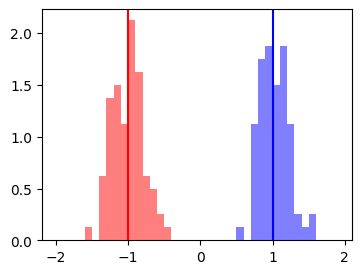

In [70]:
fig = plt.figure(figsize=(4,3))
plt.hist(YGs_1, color='blue', alpha=0.5, density=True, bins=np.arange(-2,2,0.1))
plt.axvline(YTR_1, color='blue')
plt.hist(YGs_0, color='red', alpha=0.5, density=True, bins=np.arange(-2,2,0.1))
plt.axvline(YTR_0, color='red')

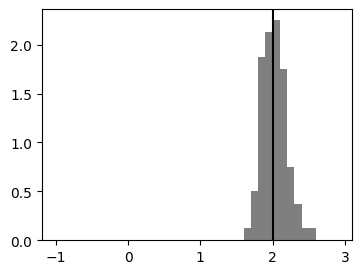

In [71]:
fig = plt.figure(figsize=(4,3))
plt.hist(YGs_d, color='black', alpha=0.5, density=True, bins=np.arange(-1,3,0.1))
plt.axvline(YTR_d, color='black')

In [72]:
np.sqrt(np.mean((YGs_d - YTR_d)**2, 0))

0.17200122999873552

## - kernel EIF

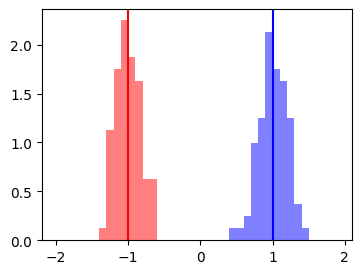

In [73]:
fig = plt.figure(figsize=(4,3))
plt.hist(YDRs_1, color='blue', alpha=0.5, density=True, bins=np.arange(-2,2,0.1))
plt.axvline(YTR_1, color='blue')
plt.hist(YDRs_0, color='red', alpha=0.5, density=True, bins=np.arange(-2,2,0.1))
plt.axvline(YTR_0, color='red')

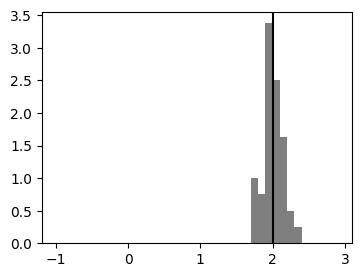

In [74]:
fig = plt.figure(figsize=(4,3))
plt.hist(YDRs_d, color='black', alpha=0.5, density = True, bins=np.arange(-1,3,0.1))
plt.axvline(YTR_d, color='black')

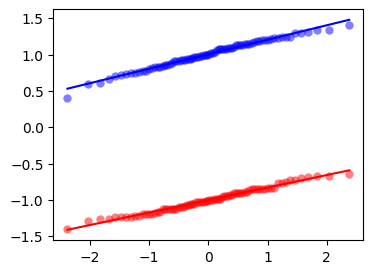

In [75]:
fig = plt.figure(figsize=(4,3)); ax=plt.gca()
stats.probplot(YDRs_1, dist="norm", plot=ax)
stats.probplot(YDRs_0, dist="norm", plot=ax)

ax.get_lines()[0].set_markerfacecolor('blue')
ax.get_lines()[0].set(alpha=0.5)
ax.get_lines()[0].set_markeredgecolor('none')
ax.get_lines()[1].set(color='blue')
ax.get_lines()[2].set_markerfacecolor('red')
ax.get_lines()[2].set(alpha=0.5)
ax.get_lines()[2].set_markeredgecolor('none')
ax.get_lines()[3].set(color='red')

# ax.legend([ax.get_lines()[0], ax.get_lines()[2]], 
#           [r'$\theta_{i^*}(\mathbf{1})$', r'$\theta_{i^*}(\mathbf{0})$'])

plt.xlabel(''); plt.ylabel('')
# plt.xlabel('Theoretical quantiles'); plt.ylabel('Ordered values')
plt.title(''); plt.show()

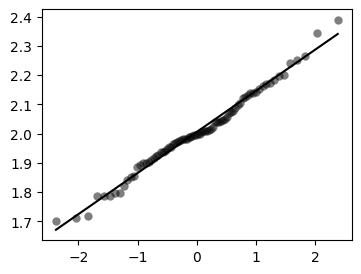

In [76]:
fig = plt.figure(figsize=(4,3)); ax=plt.gca()

stats.probplot(YDRs_d, dist="norm", plot=plt)

ax.get_lines()[0].set_markerfacecolor('black')
ax.get_lines()[0].set(alpha=0.5)
ax.get_lines()[0].set_markeredgecolor('none')
ax.get_lines()[1].set(color='black')

# ax.legend([ax.get_lines()[0]], 
#           [r'$\theta_{i^*}(\mathbf{1}) - \theta_{i^*}(\mathbf{0})$'])

plt.xlabel(''); plt.ylabel('')
# plt.xlabel('Theoretical quantiles'); plt.ylabel('Ordered values')
plt.title(''); plt.show()

# inference

## - estimated std

In [77]:
np.std(YDRs_0), np.std(YDRs_1), np.std(YDRs_d)

(0.16877470871335779, 0.19569486294930608, 0.13806292848408108)

In [78]:
np.nanmean(sd0s_hac_dr, 0), np.nanmean(sd1s_hac_dr, 0), np.nanmean(sdds_hac_dr, 0) 

(array([0.17353693, 0.17080066, 0.17187897, 0.16697863]),
 array([0.17970831, 0.17721603, 0.17720201, 0.17289426]),
 array([0.14589392, 0.14291744, 0.1395971 , 0.13915921]))

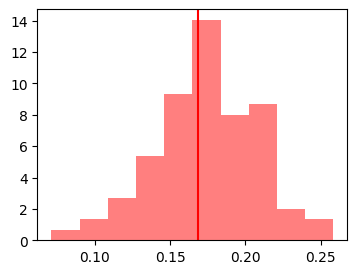

In [79]:
fig = plt.figure(figsize=(4,3))
plt.hist(sd0s_hac_dr[:,0], color='red', alpha=0.5, density=True)
plt.axvline(np.std(YDRs_0), color='red')

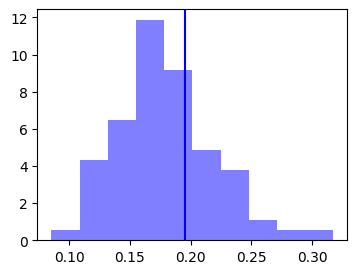

In [80]:
fig = plt.figure(figsize=(4,3))
plt.hist(sd1s_hac_dr[:,0], color='blue', alpha=0.5, density=True)
plt.axvline(np.std(YDRs_1), color='blue')

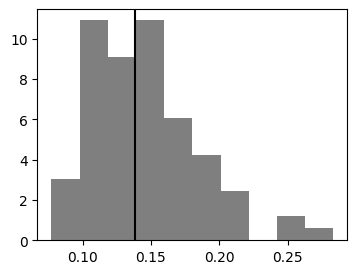

In [81]:
fig = plt.figure(figsize=(4,3))
plt.hist(sdds_hac_dr[:,0], color='black', alpha=0.5, density=True)
plt.axvline(np.std(YDRs_d), color='black')

### * coverage

In [82]:
ZDRs_0 = (
    (YDRs_0 - np.mean(YDRs_0))[:,None]
    / sd0s_hac_dr
)

In [83]:
ZDRs_1 = (
    (YDRs_1 - np.mean(YDRs_1))[:,None]
    / sd1s_hac_dr
)

In [84]:
ZDRs_d = (
    (YDRs_d - np.mean(YDRs_d))[:,None]
    / sdds_hac_dr
)

In [85]:
np.nanmean(np.abs(ZDRs_0) <= 2, 0), np.nanmean(np.abs(ZDRs_1) <= 2, 0), np.nanmean(np.abs(ZDRs_d) <= 2, 0)

(array([0.9375, 0.925 , 0.95  , 0.925 ]),
 array([0.9125, 0.9125, 0.9   , 0.8875]),
 array([0.975 , 0.95  , 0.9375, 0.9125]))

In [86]:
qs = np.linspace(0,1,42)[1:-1]

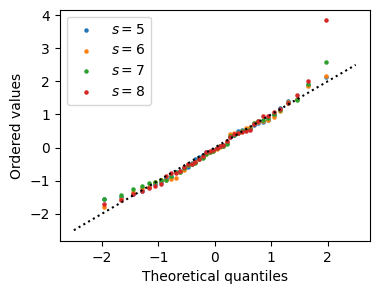

In [87]:
fig = plt.figure(figsize=(4,3))
for i, hop in enumerate(hops):
    plt.scatter(
        stats.norm.ppf(qs),
        np.nanquantile(ZDRs_0[:,i], qs, 0),
        label=r'$s = %d$'%hop, s=5
    )
plt.plot([-2.5,2.5],[-2.5,2.5], linestyle=':', color='black')
plt.xlabel('Theoretical quantiles'); plt.ylabel('Ordered values')
plt.legend()

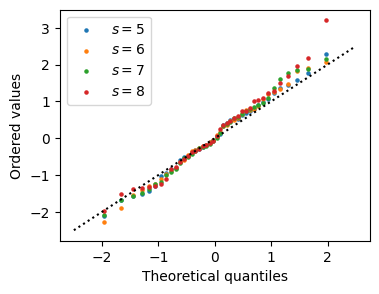

In [88]:
fig = plt.figure(figsize=(4,3))
for i, hop in enumerate(hops):
    plt.scatter(
        stats.norm.ppf(qs),
        np.nanquantile(ZDRs_1[:,i], qs, 0),
        label=r'$s = %d$'%hop, s=5
    )
plt.plot([-2.5,2.5],[-2.5,2.5], linestyle=':', color='black')
plt.xlabel('Theoretical quantiles'); plt.ylabel('Ordered values')
plt.legend()

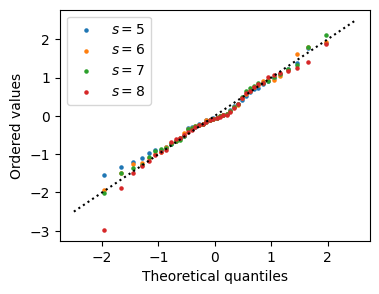

In [89]:
fig = plt.figure(figsize=(4,3))
for i, hop in enumerate(hops):
    plt.scatter(
        stats.norm.ppf(qs),
        np.nanquantile(ZDRs_d[:,i], qs, 0),
        label=r'$s = %d$'%hop, s=5
    )
plt.plot([-2.5,2.5],[-2.5,2.5], linestyle=':', color='black')
plt.xlabel('Theoretical quantiles'); plt.ylabel('Ordered values')
plt.legend()